In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from MLP import MLP
import os

In [3]:
def generate_test_data(P, K, T, N=50):
    t = torch.linspace(0, 20, N)
    P = torch.ones(N)*P
    K = torch.ones(N)*K
    T = torch.ones(N)*T

    return torch.stack([P, K, T, t]).T


def closest_value(df, col, val):
    uniques = df[col].unique()
    close_idx = np.argmin(np.abs(uniques - val))
    return uniques[close_idx]


def get_closest_values(df, P, K, T):
    p_closest = closest_value(df, 'P', P)
    T_closest = closest_value(df, 'T', T)
    subset = df[(df['P'] == p_closest) & (df['T'] == T_closest)]
    k_closest = closest_value(subset, 'K', K)
    subset = subset[df['K'] == k_closest]
    return subset

In [4]:
def compare_with_data(P, K, T, dataset, model_path, hidden_dim, n_layers):
    df = pd.read_csv(os.path.join('datasets', dataset))
    df = get_closest_values(df, P, K, T)

    data_gam = df['gamma']
    t = df['t']
    X = df[['P', 'K', 'T', 't']].values

    X = torch.tensor(X).type(torch.float)

    model = MLP.load_from_checkpoint(
        checkpoint_path=os.path.join('saved_models', model_path),
        hidden_dim=hidden_dim,
        n_layers=n_layers
        )

    pred = model(X).detach().squeeze()
    print(f"""
    Using M = {df['M'].iloc[0]}
        P = {df['P'].iloc[0]} 
        K = {df['K'].iloc[0]} 
        T = {df['T'].iloc[0]}
    Error: {((pred-data_gam).abs()/data_gam.abs()).mean()*100:.2f}%
    """)
    # {pred.shape}{data_gam.shape}

    plt.plot(t, data_gam, label='data')
    plt.plot(t, pred, label='prediction')
    plt.xlabel(r'$\tau (fm)$')
    plt.ylabel(r'$d \Gamma / dK$')
    plt.legend()
    plt.show()


    Using M = 0
        P = 16.23 
        K = 3.246 
        T = 0.261
    Error: 6.07%
    


/tmp/ipykernel_765778/4055005578.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = subset[df['K'] == k_closest]


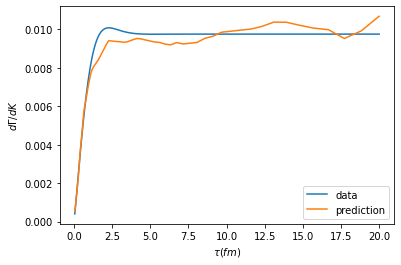

In [9]:
HIDDEN_DIM = 64
N_LAYERS = 8
DATASET = 'method_0.csv'
# model_path = 'saved_models/M_0_epoch=298.ckpt'
# model_path = 'saved_models/M_0_epoch=179crit_pc_err.ckpt'
model_path = 'M=0_epoch=265_crit=abs_err.ckpt'
P = 16
K = 3
T = 0.3

compare_with_data(P, K, T, DATASET, model_path, HIDDEN_DIM, N_LAYERS)